In [2]:
import gym
from gym import spaces
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm


import os
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np


In [83]:
class CustomEnv(gym.Env):
    
    """Custom Environment that follows gym interface"""
    metadata = {'render.modes': ['human']}

    def __init__(self, k_init):
        super(CustomEnv, self).__init__()
        self.r = 0.01
        self.k_init = k_init
        self.c_space = spaces.Box(low=np.array([0]), high=np.array([100]))
        self.k_space = spaces.Box(low=np.array([0]), high=np.array([100]))
    
    def utility(self, c):
        return 1 + c
        
    def reset(self):
        self.k = self.k_init
        self.done = False
        return self.k
    
    def step(self, c):
        self.k = (1+self.r) * self.k - c
        if self.k <=0: self.done = True
        return self.k, self.utility(c), self.done

    
    def render(self, mode='human', close=False):
        # Render the environment to the screen
        pass



In [142]:

class ReplayBuffer(object):
    def __init__(self, max_size, input_shape, n_actions):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.state_memory = np.zeros((self.mem_size, input_shape),
                                     dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, input_shape),
                                         dtype=np.float32)

        self.action_memory = np.zeros(self.mem_size, dtype=np.int64)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = done
        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, batch_size, replace=False)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        terminal = self.terminal_memory[batch]

        return states, actions, rewards, states_, terminalZ
    
    
class DeepQNetwork(nn.Module):
    def __init__(self, lr, n_actions, name, input_dims, chkpt_dir):
        super(DeepQNetwork, self).__init__()
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name)

        self.conv1 = nn.Conv2d(input_dims, 32, 8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, 3, stride=1)

        fc_input_dims = self.calculate_conv_output_dims(input_dims)

        self.fc1 = nn.Linear(fc_input_dims, 512)
        self.fc2 = nn.Linear(512, n_actions)

        self.optimizer = optim.RMSprop(self.parameters(), lr=lr)

        self.loss = nn.MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def calculate_conv_output_dims(self, input_dims):
        state = T.zeros(1, input_dims)
        dims = self.conv1(state)
        dims = self.conv2(dims)
        dims = self.conv3(dims)
        return int(np.prod(dims.size()))

    def forward(self, state):
        conv1 = F.relu(self.conv1(state))
        conv2 = F.relu(self.conv2(conv1))
        conv3 = F.relu(self.conv3(conv2))
        conv_state = conv3.view(conv3.size()[0], -1)

        flat1 = F.relu(self.fc1(conv_state))
        actions = self.fc2(flat1)

        return actions

    def save_checkpoint(self):
        print('... saving checkpoint ...')
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        print('... loading checkpoint ...')
        self.load_state_dict(T.load(self.checkpoint_file))



class DQNAgent(object):
    def __init__(self, gamma, epsilon, lr, n_actions, input_dims,
                 mem_size, batch_size, eps_min=0.01, eps_dec=5e-7,
                 replace=1000, algo=None, env_name=None, chkpt_dir='tmp/dqn'):
        self.gamma = gamma
        self.epsilon = epsilon
        self.lr = lr
        self.n_actions = n_actions
        self.input_dims = input_dims
        self.batch_size = batch_size
        self.eps_min = eps_min
        self.eps_dec = eps_dec
        self.replace_target_cnt = replace
        self.algo = algo
        self.env_name = env_name
        self.chkpt_dir = chkpt_dir
        self.action_space = [i for i in range(n_actions)]
        self.learn_step_counter = 0

        self.memory = ReplayBuffer(mem_size, input_dims, n_actions)

        self.q_eval = DeepQNetwork(self.lr, self.n_actions,
                                    input_dims=self.input_dims,
                                    name=self.env_name+'_'+self.algo+'_q_eval',
                                    chkpt_dir=self.chkpt_dir)

        self.q_next = DeepQNetwork(self.lr, self.n_actions,
                                    input_dims=self.input_dims,
                                    name=self.env_name+'_'+self.algo+'_q_next',
                                    chkpt_dir=self.chkpt_dir)

    def choose_action(self, observation):
        if np.random.random() > self.epsilon:
            state = T.tensor([observation],dtype=T.float).to(self.q_eval.device)
            actions = self.q_eval.forward(state)
            action = T.argmax(actions).item()
        else:
            action = np.random.choice(self.action_space)

        return action

    def store_transition(self, state, action, reward, state_, done):
        self.memory.store_transition(state, action, reward, state_, done)

    def sample_memory(self):
        state, action, reward, new_state, done = \
                                self.memory.sample_buffer(self.batch_size)

        states = T.tensor(state).to(self.q_eval.device)
        rewards = T.tensor(reward).to(self.q_eval.device)
        dones = T.tensor(done).to(self.q_eval.device)
        actions = T.tensor(action).to(self.q_eval.device)
        states_ = T.tensor(new_state).to(self.q_eval.device)

        return states, actions, rewards, states_, dones

    def replace_target_network(self):
        if self.learn_step_counter % self.replace_target_cnt == 0:
            self.q_next.load_state_dict(self.q_eval.state_dict())

    def decrement_epsilon(self):
        self.epsilon = self.epsilon - self.eps_dec \
                           if self.epsilon > self.eps_min else self.eps_min

    def save_models(self):
        self.q_eval.save_checkpoint()
        self.q_next.save_checkpoint()

    def load_models(self):
        self.q_eval.load_checkpoint()
        self.q_next.load_checkpoint()

    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
            return

        self.q_eval.optimizer.zero_grad()

        self.replace_target_network()

        states, actions, rewards, states_, dones = self.sample_memory()
        indices = np.arange(self.batch_size)

        q_pred = self.q_eval.forward(states)[indices, actions]
        q_next = self.q_next.forward(states_).max(dim=1)[0]

        q_next[dones] = 0.0
        q_target = rewards + self.gamma*q_next

        loss = self.q_eval.loss(q_target, q_pred).to(self.q_eval.device)
        loss.backward()
        self.q_eval.optimizer.step()
        self.learn_step_counter += 1

        self.decrement_epsilon()

In [143]:
env = CustomEnv(k_init=1)
env.reset()
env.k

1

In [144]:
env.k_space.high[0]

100.0

In [145]:
c = 0.5
k, u, done = env.step(c)
print(k, u, done)

0.51 1.5 False


In [2]:
# env = CustomEnv(k_init=1)
# env.reset()

# best_score = -np.inf
# load_checkpoint = False
# n_games = 250

# agent = DQNAgent(gamma=0.99, epsilon=1, lr=0.0001,
#                  input_dims=int(env.k_space.high),
#                  n_actions=int(env.c_space.high), mem_size=50000, eps_min=0.1,
#                  batch_size=32, replace=1000, eps_dec=1e-5,
#                  chkpt_dir='models/', algo='DQNAgent',
#                  env_name='PongNoFrameskip-v4')

# if load_checkpoint:
#     agent.load_models()

# fname = agent.algo + '_' + agent.env_name + '_lr' + str(agent.lr) +'_' \
#         + str(n_games) + 'games'
# figure_file = 'plots/' + fname + '.png'

# # if you want to record video of your agent playing, do a mkdir tmp && mkdir tmp/dqn-video
# # and uncomment the following 2 lines.
# #env = wrappers.Monitor(env, "tmp/dqn-video",
# #                    video_callable=lambda episode_id: True, force=True)

# n_steps = 0
# scores, eps_history, steps_array = [], [], []

# for i in range(n_games):
#     done = False
#     observation = env.reset()

#     score = 0
#     while not done:
#         action = agent.choose_action(observation)
#         observation_, reward, done, info = env.step(action)
#         score += reward

#         if not load_checkpoint:
#             agent.store_transition(observation, action,
#                                  reward, observation_, done)
#             agent.learn()
#         observation = observation_
#         n_steps += 1
#     scores.append(score)
#     steps_array.append(n_steps)

#     avg_score = np.mean(scores[-100:])
#     print('episode: ', i,'score: ', score,
#          ' average score %.1f' % avg_score, 'best score %.2f' % best_score,
#         'epsilon %.2f' % agent.epsilon, 'steps', n_steps)

#     if avg_score > best_score:
#         if not load_checkpoint:
#             agent.save_models()
#         best_score = avg_score

#     eps_history.append(agent.epsilon)

# x = [i+1 for i in range(len(scores))]
# plot_learning_curve(steps_array, scores, eps_history, figure_file)

In [3]:
np.zeros((1, 100),  dtype=np.float32)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)

In [5]:
class PrisonnersDilemma(gym.Env):
    
    """Custom Environment that follows gym interface"""
    metadata = {'render.modes': ['human']}

    def __init__(self):
        super(PrisonnersDilemma, self).__init__()
        self.n_agents = 2
        self.n_actions = 2
        self.n_states = 5 # (0: initial, 1: (0,0), 2: (1,0), 3: (0,1), 4: (1,1)
        self.n_games = 10
        #self.action_space = spaces.Discrete(self.n_actions)
        #self.observation_space = spaces.Discrete(self.n_states)
        
    def reset(self):
        self.state = 0
        self.game = 0
        self.done = False
        return self.state
    
    def step(self, actions):
        
        actions = [0]
        
        if actions == [0, 0]:
            rewards = [1, 1]
            self.state = 1
            
        elif actions == [1, 0]:
            rewards = [0, 3]
            self.state = 2
            
        elif actions == [0, 1]:
            rewards = [3, 0]
            self.state = 3     

        else:
            rewards = [2, 2]
            self.state = 4
            
        
        self.game +=1
        
        if self.game == self.n_games:
            self.state = 0
            self.done = True
            
        info = {}
            
        return self.state, rewards, self.done, info

    
    def render(self, mode='human', close=False):
        # Render the environment to the screen
        pass

    
# class Q_Agent():
#     def __init__(self, lr, gamma, eps_start, eps_end, eps_dec, n_actions, n_states):
        
#         self.lr = lr
#         self.gamma = gamma
#         self.epsilon = eps_start
#         self.eps_min = eps_end
#         self.eps_dec = eps_dec
        
#         self.n_actions = n_actions
#         self.n_states = n_states
        
#         self.Q = {}
#         #self.q_table = np.zeros(env.n_actions)
    
#     def policy_fn(self):
        
    
#     def select_action(self):
#         pass
    

class QAgent():
    def __init__(self, lr, gamma, n_actions, n_states, eps_start, eps_end, eps_dec):
        self.lr = lr
        self.gamma = gamma
        self.n_actions = n_actions
        self.n_states = n_states
        self.epsilon = eps_start
        self.eps_min = eps_end
        self.eps_dec = eps_dec

        self.Q = {}

        self.init_Q()

    def init_Q(self):
        for state in range(self.n_states):
            for action in range(self.n_actions):
                self.Q[(state, action)] = 0.0

    def choose_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.choice([i for i in range(self.n_actions)])
        else:
            actions = np.array([self.Q[(state, a)] \
                                for a in range(self.n_actions)])
            action = np.argmax(actions)
        return action

    def decrement_epsilon(self):
        self.epsilon = self.epsilon*self.eps_dec if self.epsilon>self.eps_min\
                       else self.eps_min

    def learn(self, state, action, reward, state_):
        actions = np.array([self.Q[(state_, a)] for a in range(self.n_actions)])
        a_max = np.argmax(actions)

        self.Q[(state, action)] += self.lr*(reward +
                                        self.gamma*self.Q[(state_, a_max)] -
                                        self.Q[(state, action)])
        self.decrement_epsilon()

class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        self.layers = nn.Sequential(
          nn.Linear(env.observation_space.n, 20),
          nn.ReLU(),
          nn.Linear(20, 20),
          nn.ReLU(),
          nn.Linear(20, env.action_space.n)
        )
        
    def forward(self, x):
        return self.layers(x)
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            state = Variable(torch.FloatTensor(state).unsqueeze(0)) 
            q_value = self.forward(state)
            action  = q_value.max(1)[1]
        else:
            action = random.randrange(env.action_space.n)
        return action


In [4]:
input_shape = int(env.c_space.high)
np.zeros((1, input_shape), dtype=np.float32)

NameError: name 'env' is not defined

In [6]:
env = PrisonnersDilemma()
env.reset()
env.state

0

In [7]:
actions = [0, 0]
new_state, rewards, done, info = env.step(actions)
print(new_state, rewards, done, env.game)

4 [2, 2] False 1


In [8]:
actions = [1, 0]
new_state, rewards, done, info = env.step(actions)
print(new_state, rewards, done, env.game)

actions = [0, 1]
new_state, rewards, done, info = env.step(actions)
print(new_state, rewards, done, env.game)

4 [2, 2] False 2
4 [2, 2] False 3


In [9]:
actions = [1, 1]
new_state, rewards, done, info = env.step(actions)
print(new_state, rewards, done, env.game)

4 [2, 2] False 4


In [10]:
done

False

In [11]:
env = PrisonnersDilemma()
n_games = 10
n_agents = env.n_agents
n_states = env.n_states
n_actions = env.n_actions
env.n_games = n_games
params = {'lr': 0.005, 
          'gamma': 0.999, 
          'eps_start': 1.0, 
          'eps_end': 0.001,
          'eps_dec': 0.995, 
          'n_actions': n_actions, 
          'n_states': n_states}

agents = [QAgent(**params) for i in range(env.n_agents)]

scores = defaultdict(list)
win_pct_list = []
n_episodes = 100000
cooperations = []
qvalues = []
actions_list = []

for i_episode in tqdm(range(n_episodes)):
    
    
    actions_episode = []
    done = False
    observation = env.reset()
    scores_episode = defaultdict(int)
    n_coops = 0
    
    while not done:
        
        actions = [agent.choose_action(observation) for agent in agents]
        observation_, rewards, done, info = env.step(actions)
        
        
        if observation_ == 4:
            n_coops += 1
       #print(observation_)
        
        for i_agent in range(n_agents):
            agents[i_agent].learn(observation, actions[i_agent], rewards[i_agent], observation_)
            scores_episode[i_agent] += rewards[i_agent]
            
        observation = observation_
    
        
        actions_episode.append(actions)
    actions_list.append(actions_episode)
    qvalues.append(agents[0].Q)
    for i_agent in range(n_agents):
        scores[i_agent].append(scores_episode[i_agent])
        
    cooperations.append(n_coops/env.n_games)
    
    if i_episode % 100 == 0:
        
        win_pct = [np.mean(scores[i][-100:]) for i in range(n_agents)]
        print('episode ', i_episode, 
              '\n Mean Reward Agent 1 %.2f' % win_pct[0],
              '\n Mean Reward Agent 2 %.2f' % win_pct[1],
              '\n epsilon %.2f' % agents[0].epsilon)

  0%|          | 0/100000 [00:00<?, ?it/s]

episode  0 
 Mean Reward Agent 1 20.00 
 Mean Reward Agent 2 20.00 
 epsilon 0.95
episode  100 
 Mean Reward Agent 1 20.00 
 Mean Reward Agent 2 20.00 
 epsilon 0.01
episode  200 
 Mean Reward Agent 1 20.00 
 Mean Reward Agent 2 20.00 
 epsilon 0.00
episode  300 
 Mean Reward Agent 1 20.00 
 Mean Reward Agent 2 20.00 
 epsilon 0.00
episode  400 
 Mean Reward Agent 1 20.00 
 Mean Reward Agent 2 20.00 
 epsilon 0.00
episode  500 
 Mean Reward Agent 1 20.00 
 Mean Reward Agent 2 20.00 
 epsilon 0.00
episode  600 
 Mean Reward Agent 1 20.00 
 Mean Reward Agent 2 20.00 
 epsilon 0.00
episode  700 
 Mean Reward Agent 1 20.00 
 Mean Reward Agent 2 20.00 
 epsilon 0.00
episode  800 
 Mean Reward Agent 1 20.00 
 Mean Reward Agent 2 20.00 
 epsilon 0.00
episode  900 
 Mean Reward Agent 1 20.00 
 Mean Reward Agent 2 20.00 
 epsilon 0.00
episode  1000 
 Mean Reward Agent 1 20.00 
 Mean Reward Agent 2 20.00 
 epsilon 0.00
episode  1100 
 Mean Reward Agent 1 20.00 
 Mean Reward Agent 2 20.00 
 epsil

episode  10000 
 Mean Reward Agent 1 20.00 
 Mean Reward Agent 2 20.00 
 epsilon 0.00
episode  10100 
 Mean Reward Agent 1 20.00 
 Mean Reward Agent 2 20.00 
 epsilon 0.00
episode  10200 
 Mean Reward Agent 1 20.00 
 Mean Reward Agent 2 20.00 
 epsilon 0.00
episode  10300 
 Mean Reward Agent 1 20.00 
 Mean Reward Agent 2 20.00 
 epsilon 0.00
episode  10400 
 Mean Reward Agent 1 20.00 
 Mean Reward Agent 2 20.00 
 epsilon 0.00
episode  10500 
 Mean Reward Agent 1 20.00 
 Mean Reward Agent 2 20.00 
 epsilon 0.00
episode  10600 
 Mean Reward Agent 1 20.00 
 Mean Reward Agent 2 20.00 
 epsilon 0.00
episode  10700 
 Mean Reward Agent 1 20.00 
 Mean Reward Agent 2 20.00 
 epsilon 0.00
episode  10800 
 Mean Reward Agent 1 20.00 
 Mean Reward Agent 2 20.00 
 epsilon 0.00
episode  10900 
 Mean Reward Agent 1 20.00 
 Mean Reward Agent 2 20.00 
 epsilon 0.00
episode  11000 
 Mean Reward Agent 1 20.00 
 Mean Reward Agent 2 20.00 
 epsilon 0.00
episode  11100 
 Mean Reward Agent 1 20.00 
 Mean Rewa

KeyboardInterrupt: 

In [12]:
observation_

4

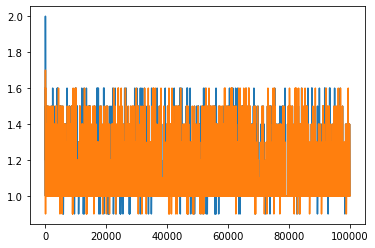

In [66]:
plt.plot([x/n_games for x in scores[0]])
plt.plot([x/n_games for x in scores[1]])

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

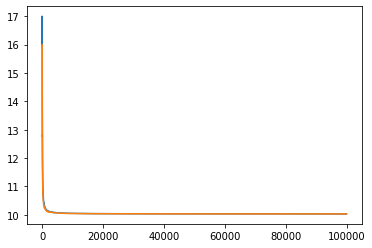

In [67]:
plt.plot([np.mean(scores[0][:i]) for i in tqdm(range(n_episodes))])
plt.plot([np.mean(scores[1][:i]) for i in tqdm(range(n_episodes))])

In [ ]:
plt.plot([np.mean([x/n_games for x in scores[0]][i-n_games:i]) for i in tqdm(range(n_episodes))])
plt.plot([np.mean([x/n_games for x in scores[1]][i-n_games:i]) for i in tqdm(range(n_episodes))])

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

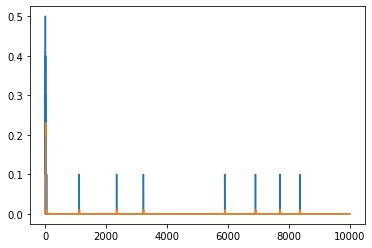

In [59]:
plt.plot(cooperations)
plt.plot([np.mean(cooperations[i-n_games:i]) for i in tqdm(range(n_episodes))])

In [60]:
def eff(score_1, score_2):
    return (score_1 + score_2)/(4*n_games)
    
efficiency = [eff(scores[0][i], scores[1][i]) for i in tqdm(range(n_episodes))]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

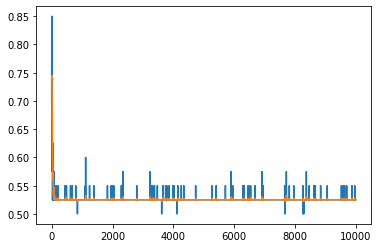

In [61]:
plt.plot(efficiency)
plt.plot([np.mean(efficiency[i-n_games:i]) for i in tqdm(range(n_episodes))])

In [62]:
efficiency[-10:]

[0.525, 0.525, 0.525, 0.525, 0.525, 0.525, 0.525, 0.525, 0.525, 0.525]

In [63]:
actions_list[-10:]

[[[1, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0]],
 [[1, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0]],
 [[1, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0]],
 [[1, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0]],
 [[1, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0]],
 [[1, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0]],
 [[1, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0]],
 [[1, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0]],
 [[1, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0]],
 [[1, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
 

dict_keys([0, 1, -5, 2, 3])

In [486]:
for i in range(2):
    actions[i] = agent[i].select_action(state)

new_state, rewards, done = env.step(actions)


AttributeError: 'Agent' object has no attribute 'select_action'